# Out Of Fold

out of fold とは学習時に$n$だけ学習データセットを区切り, $n-1$ 個でモデルを学習しのこりの一つのブロックに対して予測を行なうことを指します。

これによってデータセットと同じ大きさの予測値の集合ができ、なおかつこれらは予測時にそのブロックに対応する予測ラベルを与えられていないため特徴量として使うことが出来ます。(これを out of fold feature と呼びます)

また純粋な予測値でも有るため out of fold feature と train target との間のロス関数を計算することでモデルの良し悪しを計算できます。

In [1]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_moons
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


X, y = make_moons(n_samples=400, noise=.3, random_state=1)

In [2]:
def plot_train_scatter(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
        
    colors = {
        0: 'b',
        1: 'r'
    }
    for t in range(2):
        idx = y == t
        ax.scatter(X[idx, 0], X[idx, 1], s=50, linewidth=1, edgecolor='w', c=colors.get(t), alpha=.8)
    return ax

plot_train_scatter()

In [3]:
fold = StratifiedKFold(n_splits=5)
oof_pred = np.zeros_like(y, dtype=np.float32)

In [4]:
for idx_train, idx_valid in fold.split(X, y):
    x_train, y_train = X[idx_train], y[idx_train]
    x_valid, y_valid = X[idx_valid], y[idx_valid]
    
    clf = LogisticRegressionCV(cv=5)
    clf.fit(x_train, y_train)
    oof_pred[idx_valid] = clf.predict_proba(x_valid)[:, 1]

In [5]:
print('auc: {}'.format(roc_auc_score(y, oof_pred)))

In [6]:
df_pred = pd.DataFrame()
df_pred['logistic_cv'] = oof_pred

## Vivid Out of Fold Module

In [7]:
from vivid.out_of_fold import linear
from vivid.utils import set_optuna_silent

In [8]:
# optuna logging を静かにする
set_optuna_silent()

In [9]:
oof_model = linear.LogisticOutOfFold(name='vivid_logistic', n_trials=400, n_jobs=-1)

In [10]:
import pandas as pd

In [11]:
df_train = pd.DataFrame(X)

In [12]:
_df = oof_model.fit(df_train, y)
df_pred = pd.concat([df_pred, _df], axis=1)

best trial params: {'C': 0.011071867482653753}
best value: -0.931125
best model paras {'solver': 'liblinear', 'penalty': 'l2', 'input_scaling': 'standard', 'n_jobs': 1, 'C': 0.011071867482653753}


0.903 -> 0.9078 へ若干の改善

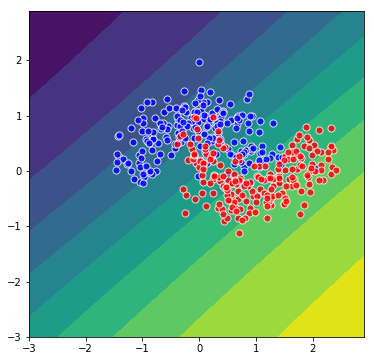

In [13]:
xx, yy = np.meshgrid(np.arange(-3, 3, .1), np.arange(-3, 3, .1))
df_mesh = oof_model.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()]))
z = df_mesh.values.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(6, 6,))
ax.contourf(xx, yy, z, levels=10, cmap="viridis")
ax = plot_train_scatter(ax)

In [14]:
from vivid.out_of_fold.boosting import XGBoostClassifierOutOfFold

In [15]:
oof_xgb = XGBoostClassifierOutOfFold(name='xgb_simple')

In [16]:
_df = oof_xgb.fit(df_train, y)

In [17]:
df_pred = pd.concat([df_pred, _df], axis=1)

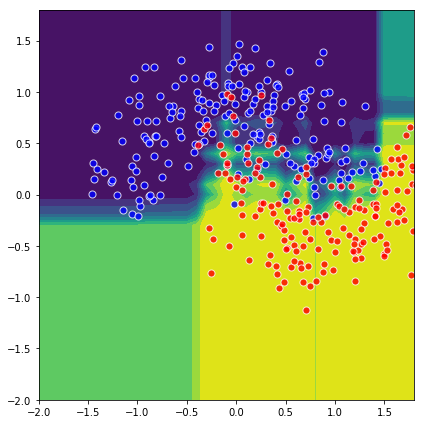

In [18]:
xx, yy = np.meshgrid(np.arange(-2, 2, .1), np.arange(-2, 2, .1))
df_mesh = oof_xgb.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()]))
z = df_mesh.values.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(6, 6,))
ax.contourf(xx, yy, z, levels=10, cmap="viridis", vmin=0, vmax=1)
ax = plot_train_scatter(ax)
ax.set_xlim(ax.set_ylim(-2, 1.8))
fig.tight_layout()

In [19]:
from vivid.out_of_fold.boosting import OptunaXGBClassifierOutOfFold

In [20]:
oof_optunide_xgb = OptunaXGBClassifierOutOfFold(name='optunied_xgb')

In [21]:
_df = oof_optunide_xgb.fit(df_train, y)

best trial params: {'reg_lambda': 0.0041847229480349276, 'reg_alpha': 0.015060725738415708, 'colsample_bytree': 1.0, 'subsample': 1.0, 'max_depth': 8, 'min_child_weight': 5}
best value: -0.9600625
best model paras {'reg_lambda': 0.0041847229480349276, 'reg_alpha': 0.015060725738415708, 'colsample_bytree': 1.0, 'subsample': 1.0, 'max_depth': 8, 'min_child_weight': 5}


In [22]:
df_pred = pd.concat([df_pred, _df], axis=1)

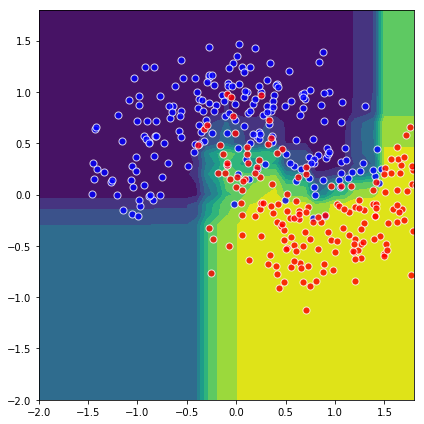

In [23]:
xx, yy = np.meshgrid(np.arange(-2, 2, .1), np.arange(-2, 2, .1))
df_mesh = oof_optunide_xgb.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()]))
z = df_mesh.values.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(6, 6,))
ax.contourf(xx, yy, z, levels=10, cmap="viridis", vmin=0, vmax=1)
ax = plot_train_scatter(ax)
ax.set_xlim(ax.set_ylim(-2, 1.8))
fig.tight_layout()

## Evaluation

check out of fold predict score

In [24]:
from vivid.metrics import binary_metrics

In [25]:
df_score = pd.concat([binary_metrics(y, y_pred).rename(columns=dict(score=name)) for name, y_pred in df_pred.T.iterrows()], axis=1)

In [26]:
df_score

,logistic_cv,vivid_logistic,xgb_simple,optunied_xgb
auc,0.927500,0.917250,0.938050,0.958963
log_loss,0.347133,0.518555,0.356473,0.260410
f1_score,0.837438,0.817734,0.862155,0.898990
accuracy,0.835000,0.815000,0.862500,0.900000


In [28]:
df_pred.corr()

,logistic_cv,vivid_logistic,xgb_simple,optunied_xgb
logistic_cv,1.000000,0.943283,0.866630,0.897000
vivid_logistic,0.943283,1.000000,0.818499,0.843339
xgb_simple,0.866630,0.818499,1.000000,0.951094
optunied_xgb,0.897000,0.843339,0.951094,1.000000
